In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-02-16 09:16:45.855634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 09:16:45.855649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('./data/ouput.csv')

In [3]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061


In [4]:
df.shape

(396562, 3)

In [5]:
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
max_value_energy


4.595

In [6]:
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)

In [7]:
# Sorting the values
df.sort_values('tstp', inplace=True)

In [8]:
df.head()

,LCLid,tstp,energy(kWh/hh)
356842,MAC000150,2011-11-23 10:00:00,0.065506
356843,MAC000150,2011-11-23 10:30:00,0.027639
356844,MAC000150,2011-11-23 11:00:00,0.043743
356845,MAC000150,2011-11-23 11:30:00,0.122742
356846,MAC000150,2011-11-23 12:00:00,0.034603


In [9]:
df['energy(kWh/hh)'].max()

1.0

In [10]:
df['energy(kWh/hh)'].min()

0.0

In [11]:
def create_X_Y(ts: list, lag: int) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """

    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, Y

In [12]:
# Deep Learning (LSTM)

# Defining the number of neurons in the LSTM layer
n_layer = 5

# Defining how many lags will be used in the time series
n_lag = 3


# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

model.summary()

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


2022-02-16 09:16:49.238368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:16:49.238838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 09:16:49.238889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-16 09:16:49.238932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-16 09:16:49.238975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [13]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """

    def __init__(self, data: pd.DataFrame, Y_var: str, lag: int, LSTM_layer_depth: int, epochs=10, batch_size=256, train_test_split=0):
        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
    
    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    


In [14]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [15]:
#normalizedtstp = (hh["tstp"] - hh["tstp"].mean()) / hh["tstp"].std()
#normalizedtstp
type(hh.iloc[0]["energy(kWh/hh)"])

numpy.float64

In [16]:
# Initiating the class
deep_learner = DeepModelTS(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)


In [17]:
# Fitting the model

model = deep_learner.LSTModel()

Epoch 1/10
66/66 [==============================] - 1s 13ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 2/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 3/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 4/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 5/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 6/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 7/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 8/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 10/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0050 - val_loss: 0.0051


In [18]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

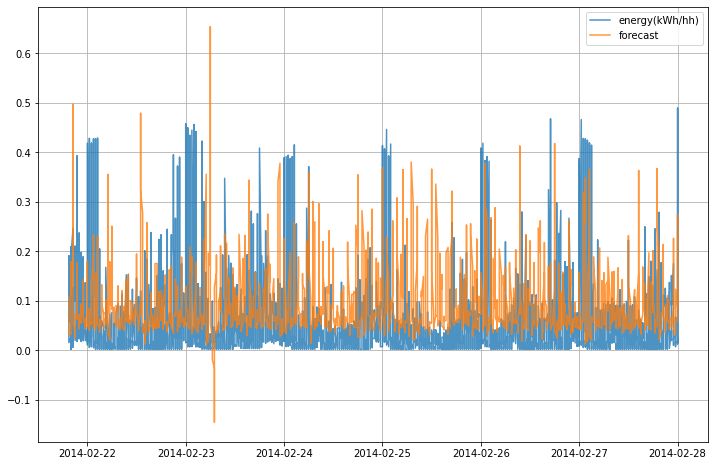

In [19]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

Epoch 1/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0085
Epoch 2/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0066
Epoch 3/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0057
Epoch 4/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0054
Epoch 5/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0053
Epoch 6/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0052
Epoch 7/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0051
Epoch 8/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0051
Epoch 9/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0050
Epoch 10/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0050


/tmp/ipykernel_32445/3518857840.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


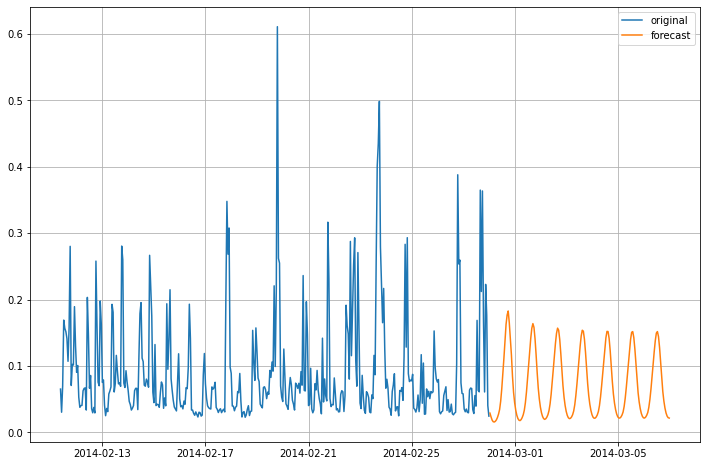

In [20]:
# Forecasting n steps ahead   

# Creating the model using full data and forecasting n steps ahead
deep_learner = DeepModelTS(
    data=hh, 
    Y_var='energy(kWh/hh)',
    lag=24,
    LSTM_layer_depth=64,
    epochs=10,
    train_test_split=0 
)

# Fitting the model 
deep_learner.LSTModel()

# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

# Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

# Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   